# Using Convolution Neural Networks to classify Seedlings

#### This can also be found on my PGAIML GitHib repo: https://github.com/GreatLearningAIML1/gl-pgp-aiml-uta-intl-jul20-94Sip

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras import datasets, models, layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from google.colab.patches import cv2_imshow
import cv2

In [3]:
the_images = np.load ('/content/drive/MyDrive/PGAIML/images.npy')

the_labels = pd.read_csv('/content/drive/MyDrive/PGAIML/imageLabels.csv')

In [4]:
the_labels.describe()

,Label
count,4750
unique,12
top,Loose Silky-bent
freq,654


In [5]:
the_labels.shape

(4750, 1)

In [6]:
the_labels.tail(5)

,Label
4745,Loose Silky-bent
4746,Loose Silky-bent
4747,Loose Silky-bent
4748,Loose Silky-bent
4749,Loose Silky-bent


In [7]:
the_labels.nunique()

Label    12
dtype: int64

In [8]:
the_images.shape

(4750, 128, 128, 3)

### Visualize the first 9 images

#### Notes: 


1.   I know this was not required, but I wanted to learn the tf.data.Dataset api, so I am using that
2.   I am shuffling the Dataset so the 9 images I am showing are randomly chosen from the dataset

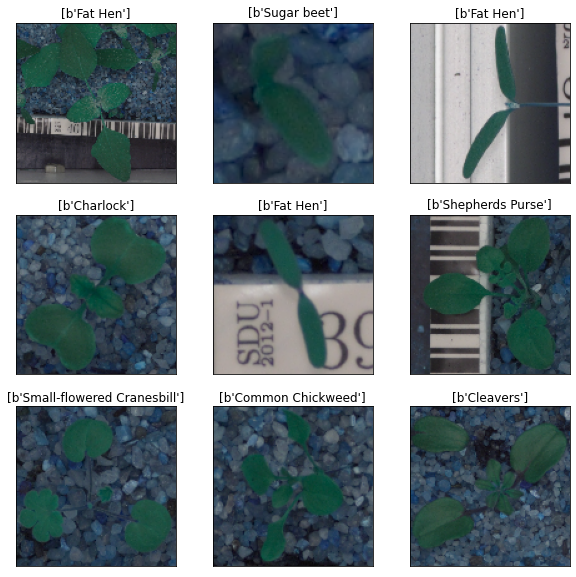

In [9]:
import tensorflow as tf

# from https://www.tensorflow.org/tutorials/load_data/numpy

ds = tf.data.Dataset.from_tensor_slices((the_images, the_labels)).shuffle(buffer_size=len(the_images), reshuffle_each_iteration=False)

#just getting first 9 pictures
ds1 = ds.batch(9)
images, labels = next(iter(ds1))
fig = plt.figure(figsize=(10,10))
for i, (image,label) in enumerate(zip(images,labels)):
  ax = fig.add_subplot(3,3,i+1)
  ax.set_xticks([]);ax.set_yticks([]);
  ax.imshow(image)
  ax.set_title(f'{label}')

plt.show()

### Pre-Processing

#### Note: I am going to apply normalization later as a part of the Dataset pipeline

In [11]:
def normalize_ds(image,label):
  image = tf.cast(image, tf.float32)
  image /= 255.0
  return image, label

In [12]:
pip install tensorflow-addons

In [13]:
import tensorflow_addons as tfa

def blur(image, label):
  image = tfa.image.gaussian_filter2d(image=image, filter_shape=(5, 5), sigma=1.0)
  return image, label


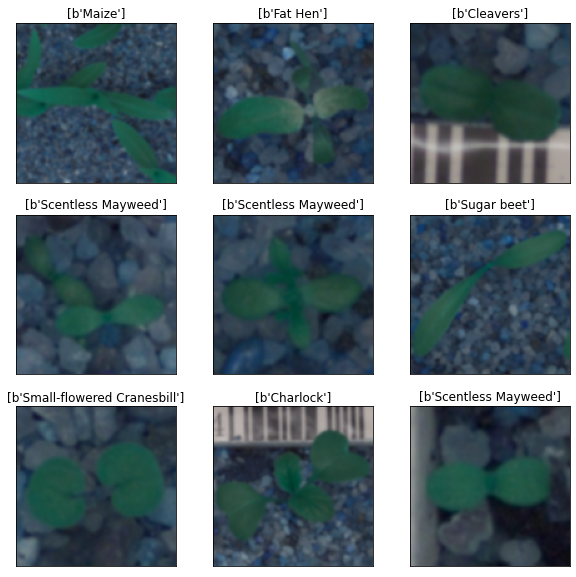

In [14]:
ds = tf.data.Dataset.from_tensor_slices((the_images, the_labels)).shuffle(buffer_size=len(the_images), reshuffle_each_iteration=False)
ds=ds.map(normalize_ds, num_parallel_calls=tf.data.AUTOTUNE)
ds=ds.map(blur, num_parallel_calls=tf.data.AUTOTUNE)

#just getting first 9 pictures
ds1 = ds.batch(9)

images, labels = next(iter(ds1))

fig = plt.figure(figsize=(10,10))
for i, (image,label) in enumerate(zip(images,labels)):
  ax = fig.add_subplot(3,3,i+1)
  ax.set_xticks([]);ax.set_yticks([]);
  ax.imshow(image)
  ax.set_title(f'{label}')

plt.show()

### Make Data Compatible for Modeling

#### One-hot encoding

Note: using LabelBinarizer since the labels are given to us as strings

In [15]:
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
oh_labels = enc.fit_transform(the_labels)
print(oh_labels.shape)

(4750, 12)


In [16]:
oh_labels[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [17]:
oh_classes = np.argmax(oh_labels,axis=1)

In [18]:
oh_classes[0]

10

#### Creating a dictionary of the class labels

In [19]:
the_labels['oh_class'] = oh_classes

In [20]:
the_labels.tail(10)

,Label,oh_class
4740,Loose Silky-bent,6
4741,Loose Silky-bent,6
4742,Loose Silky-bent,6
4743,Loose Silky-bent,6
4744,Loose Silky-bent,6
4745,Loose Silky-bent,6
4746,Loose Silky-bent,6
4747,Loose Silky-bent,6
4748,Loose Silky-bent,6
4749,Loose Silky-bent,6


In [21]:
unique_classes = the_labels.drop_duplicates(keep="first", inplace=False)

unique_classes.head(15)

,Label,oh_class
0,Small-flowered Cranesbill,10
496,Fat Hen,5
971,Shepherds Purse,9
1202,Common wheat,4
1423,Common Chickweed,3
2034,Charlock,1
2424,Cleavers,2
2711,Scentless Mayweed,8
3227,Sugar beet,11
3612,Maize,7


In [22]:
unique_classes.set_index('oh_class',inplace=True)

In [23]:
unique_classes

,Label
oh_class,
10,Small-flowered Cranesbill
5,Fat Hen
9,Shepherds Purse
4,Common wheat
3,Common Chickweed
1,Charlock
2,Cleavers
8,Scentless Mayweed
11,Sugar beet


In [24]:
meta_class_dict = unique_classes.to_dict()


In [25]:
class_dict = meta_class_dict['Label']

In [26]:
class_dict

{0: 'Black-grass',
 1: 'Charlock',
 2: 'Cleavers',
 3: 'Common Chickweed',
 4: 'Common wheat',
 5: 'Fat Hen',
 6: 'Loose Silky-bent',
 7: 'Maize',
 8: 'Scentless Mayweed',
 9: 'Shepherds Purse',
 10: 'Small-flowered Cranesbill',
 11: 'Sugar beet'}

#### Create Train, Validation and Test Datasets

In [27]:
DATASET_SIZE = len(the_images)
BATCH_SIZE = 32
BUFFER_SIZE = len(the_images)

tf.random.set_seed(55)

train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)

# load fresh dataset
full_dataset = tf.data.Dataset.from_tensor_slices((the_images, oh_labels))

#this normalizes the entire dataset before splitting
full_dataset=full_dataset.map(normalize_ds, num_parallel_calls=tf.data.AUTOTUNE)
full_dataset=full_dataset.map(blur, num_parallel_calls=tf.data.AUTOTUNE)

#now I am going to shuffle the entire dataset before splitting
full_dataset = full_dataset.shuffle(buffer_size=DATASET_SIZE, reshuffle_each_iteration=False)

train_ds = full_dataset.take(train_size)
val_test_dataset = full_dataset.skip(train_size)
val_ds = val_test_dataset.skip(val_size)
test_ds = val_test_dataset.take(test_size)

print(f'Size of Training dataset is {tf.data.experimental.cardinality(train_ds).numpy()}\n')
print(f'Size of Validation dataset is {tf.data.experimental.cardinality(val_ds).numpy()}\n')
print(f'Size of Test dataset is {tf.data.experimental.cardinality(test_ds).numpy()}\n')

Size of Training dataset is 3325

Size of Validation dataset is 713

Size of Test dataset is 712



In [28]:
#set the batch sizes
train_ds = train_ds.batch(BATCH_SIZE)
#test_ds = test_ds.batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)

#### Note: the below shows a batch size of 8 since I printed this out testing with batch size of 8. It still shows ready for modeling.

In [80]:
#demonstrate batch is set and ready for training
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(8, 128, 128, 3)
(8, 12)


#### The dataset is ready for training, and data is in the proper form, the above output shows NHWC format: 
N = number of samples (64, size of batch)
H=W: size of image
C = channels, 3 for RGB

### Build the Model!

In [29]:
#optimize datasets for performance
AUTOTUNE = tf.data.AUTOTUNE

#using data augmentation with the training dataset
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])


train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

#cache will cache data from first epoch so subsequent epochs are faster
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Some references used to create the model


1.   https://vincentblog.xyz/posts/dropout-y-batch-normalization
2.   https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html



In [30]:
num_classes = 12

head = models.Sequential()

head.add(layers.Conv2D(32, 5, use_bias=False, padding='same', input_shape=(128,128,3)))
head.add(layers.BatchNormalization())
head.add(layers.Activation('relu'))
head.add(layers.MaxPooling2D(pool_size = (2, 2)))
#head.add(layers.Dropout(0.1))

head.add(layers.Conv2D(32, 5, use_bias=False, padding='same'))
head.add(layers.BatchNormalization())
head.add(layers.Activation('relu'))
head.add(layers.MaxPooling2D(pool_size = (2, 2)))
#head.add(layers.Dropout(0.1))

head.add(layers.Conv2D(48, 5, use_bias=False, padding='same'))
head.add(layers.BatchNormalization())
head.add(layers.Activation('relu'))
head.add(layers.MaxPooling2D(pool_size = (2, 2)))
#head.add(layers.Dropout(0.2))

#not using BatchNormalization in this model since there are not multiple hidden layers, which is when BN is most effective
cls= models.Sequential()
cls.add(layers.GlobalMaxPooling2D())
cls.add(layers.Dropout(0.1))
cls.add(layers.Dense(64))
cls.add(layers.Activation('relu'))
cls.add(layers.Dropout(0.2))

cls.add(layers.Dense(num_classes, activation="softmax"))

cnn_model = models.Sequential([
    head, 
    cls
])

In [31]:
opt = optimizers.Adam(learning_rate=0.0003)

In [32]:

cnn_model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy','Precision'])

In [33]:
cnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 16, 16, 48)        66848     
_________________________________________________________________
sequential_2 (Sequential)    (None, 12)                3916      
Total params: 70,764
Trainable params: 70,540
Non-trainable params: 224
_________________________________________________________________


### Fit & Evaluate Model

In [34]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=12)

history = cnn_model.fit(train_ds,
                  validation_data=val_ds,
                  epochs=150,
                  verbose=1,
                  callbacks=[early_stopping])

hist  = pd.DataFrame(history.history)
hist.tail(10)

Epoch 1/150
104/104 [==============================] - 70s 369ms/step - loss: 3.3771 - accuracy: 0.0818 - precision: 0.0689 - val_loss: 2.4779 - val_accuracy: 0.0603 - val_precision: 0.0000e+00
Epoch 2/150
104/104 [==============================] - 3s 24ms/step - loss: 2.2860 - accuracy: 0.2187 - precision: 0.2850 - val_loss: 2.4564 - val_accuracy: 0.0884 - val_precision: 0.0000e+00
Epoch 3/150
104/104 [==============================] - 3s 24ms/step - loss: 2.0443 - accuracy: 0.2972 - precision: 0.6613 - val_loss: 2.4206 - val_accuracy: 0.1781 - val_precision: 0.0000e+00
Epoch 4/150
104/104 [==============================] - 3s 24ms/step - loss: 1.8137 - accuracy: 0.3736 - precision: 0.6715 - val_loss: 2.3647 - val_accuracy: 0.1823 - val_precision: 1.0000
Epoch 5/150
104/104 [==============================] - 2s 24ms/step - loss: 1.6507 - accuracy: 0.4367 - precision: 0.6740 - val_loss: 1.7998 - val_accuracy: 0.3464 - val_precision: 0.8526
Epoch 6/150
104/104 [=========================

,loss,accuracy,precision,val_loss,val_accuracy,val_precision
72,0.316879,0.890226,0.916270,0.420929,0.866760,0.888724
73,0.306003,0.894737,0.920969,0.694443,0.788219,0.811463
74,0.336798,0.885113,0.914358,0.384747,0.877980,0.898380
75,0.299817,0.901053,0.924653,0.313639,0.901823,0.910791
76,0.324253,0.896541,0.916272,0.567640,0.814867,0.844512
77,0.308437,0.894135,0.918509,0.359661,0.890603,0.903874
78,0.313703,0.889925,0.915421,0.378148,0.879383,0.900741
79,0.287200,0.897444,0.917714,0.350914,0.886396,0.909091
80,0.311320,0.893835,0.918645,0.394167,0.852735,0.876652
81,0.305400,0.896842,0.919508,0.543491,0.806452,0.835575


In [35]:
hist['epoch'] = history.epoch

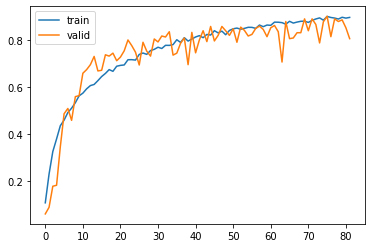

In [36]:
plt.plot(hist['accuracy'])
plt.plot(hist['val_accuracy'])
plt.legend(("train" , "valid") , loc =0)

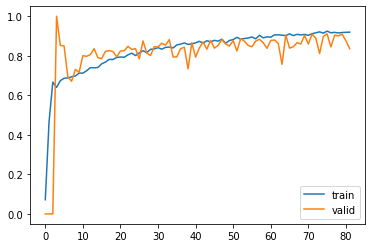

In [37]:
plt.plot(hist['precision'])
plt.plot(hist['val_precision'])
plt.legend(("train" , "valid") , loc =0)

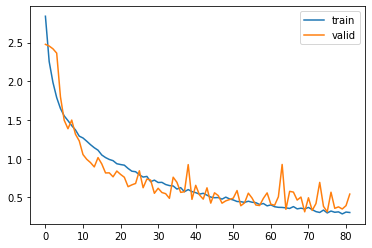

In [38]:
# plot training history
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(("train" , "valid") , loc =0)
plt.show()

#### Observations about Model Performance:
1.   The validation curves were "noisy". I believe this was due to the small size of the dataset.
2.   I chose precision as a performance measure as I believe it helps to evaluate classification accuracy for the stated business objective.




### Evaluate Model

In [40]:
# Score trained model.

test_ds = test_ds.batch(64)

results = cnn_model.evaluate(test_ds)
print(f'Test loss: {results[0]}, Test accuracy: {results[1]}, Test precision: {results[2]}')

12/12 [==============================] - 30s 23ms/step - loss: 0.5551 - accuracy: 0.8244 - precision: 0.8426
Test loss: 0.5550809502601624, Test accuracy: 0.824438214302063, Test precision: 0.8426470756530762


#### NOTE:
I am calculating predictions this way because I used the Tensorflow Datasets capability.

In [52]:
predicted_classes = np.array([])
actual_labels =  []
test_images = []

#this returns a batch of x's and y's
for test_image_batch, test_label_batch in test_ds:
  prediction = cnn_model.predict(test_image_batch, verbose=0)
  pred_class = tf.argmax(prediction, axis=1)
  predicted_classes = np.concatenate([predicted_classes, pred_class])

  #loop over each image in the batch
  for idx in range(len(test_image_batch)):
    test_images.append(test_image_batch[idx])
    actual_labels.append(np.argmax(test_label_batch[idx], axis=-1))

### Confusion Matrix

In [54]:
#printing out TensorFlow Confusion Matrix

con_mat = tf.math.confusion_matrix(labels=actual_labels, predictions=predicted_classes).numpy()

In [55]:
con_mat

array([[20,  0,  0,  0,  1,  0, 17,  0,  1,  0,  0,  0],
       [ 0, 54,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0],
       [ 0, 11, 26,  0,  1,  0,  0,  0,  1,  1,  0,  0],
       [ 0,  0,  0, 84,  0,  0,  0,  0,  3,  1,  0,  0],
       [ 3,  0,  0,  0, 30,  0,  3,  1,  2,  0,  0,  1],
       [ 1,  0,  0,  1,  3, 44, 12,  0,  2,  1,  0,  0],
       [13,  0,  0,  0,  0,  0, 87,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 28,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  1,  0, 89,  2,  0,  0],
       [ 0,  0,  0,  4,  0,  0,  0,  0,  6, 21,  0,  0],
       [ 0,  5,  1,  4,  0,  0,  0,  3,  0, 12, 51,  2],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0, 53]], dtype=int32)

#### Observations shows the number of correct predictions in each class. The numbers along the diagonals are the raw number of correct predicitons. The numbers of the diagonals show the "missed" predictions. So, for example:

1.   For the last class, 18 were predicted correctly, twenty (20) were wrongly predicted as class '5', eight were wrongly classified as class '8', five were wrongly classified as class '9', and so on.

#### Normalize Confusion Matrix to the interpretation of which class is being misclassified.

In [56]:
class_labels = [0,1,2,3,4,5,6,7,8,9,10,11]
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = class_labels, 
                     columns = class_labels)

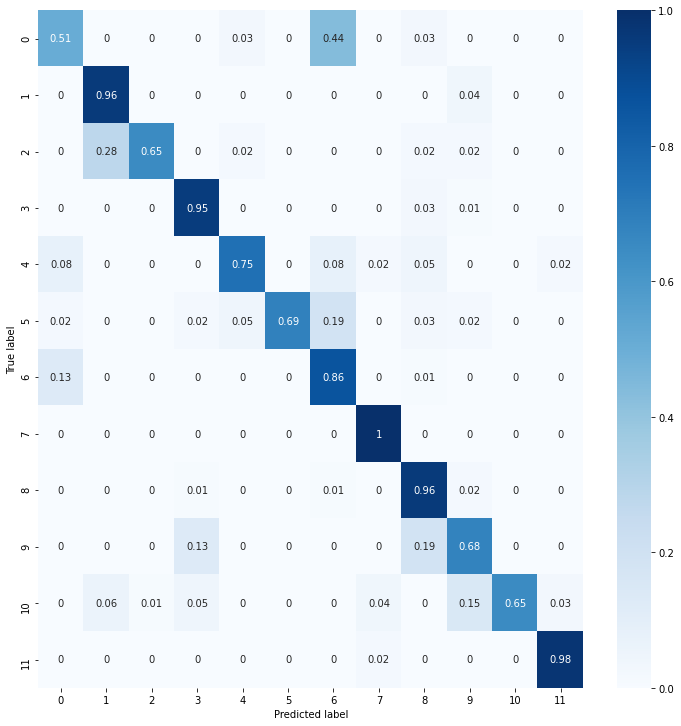

In [57]:
figure = plt.figure(figsize=(10, 10))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

#### Observations on Confusion Matrix:

1.   The diagonal show the percent of correct predictions for each class.
2.   


### Visualize Predictions

Based on the below images, the model looks to have correctly predicted the seedling type.
This makes sense becuase these classes 8,11,6, and 1 were all classes where the heatmap shows strong predictive capability.

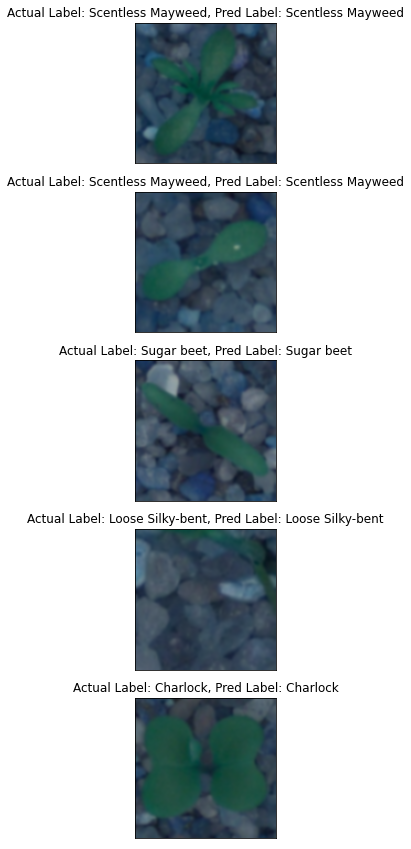

In [61]:
visualize =[2,3,33,36,59]
fig = plt.figure(figsize=(15,15))
i=0

for im_idx in visualize:
  ax = fig.add_subplot(5,1,i+1)
  ax.set_xticks([]);ax.set_yticks([]);
  ax.imshow(test_images[im_idx])
  ax.set_title(f'Actual Label: {class_dict[actual_labels[im_idx]]}, Pred Label: {class_dict[predicted_classes[im_idx]]}')
  i=i+1
plt.show()

